In [64]:
!pip install xgboost

In [65]:
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set(style="darkgrid")
plt.rcParams["patch.force_edgecolor"] = True

In [66]:
df_train = pd.read_csv('train.csv')

Lets see the no. of passengers in our training data

In [67]:
print("The no. of passengers in our training data are: ", len(df_train))

The no. of passengers in our training data are:  891


In [68]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can see that there are 9 features for every passenger. We have one binary predictor variable called 'Survived'. There are the following types of variables we need to analyse in this dataset:

1. **Numerical or Continuous Variables**: They can have any value within a specified range. There can be infinitely many continous values in any given range. In the given dataset ***'Age'*** and ***'Fare'*** are continuous variables.


2. **Categorical variables**: They only have discrete values. Like the ***'Sex'*** Column which has two values here namely 'male' and 'female'. The categorical variables are ***'Pclass'***, ***'Sex'***, ***'SibSp'***, ***'Parch'***, ***'Cabin'***, ***'Embarked'***.


3. **Target Variable**: This is the variable we need to predict. It can be either continuous(Regression) or discrete(Classification) . In the given dataset our target variable, ***'Survived'*** is a binary categorical variable. It has only 2 values:   '1'(Survived) and '0'(Not Survived) 


Finally we have 3 more variables ***'PassengerId'***, ***'Name'*** and ***'Ticket'***. These will be unique for every passenger and only serve as an identification value. We don't need them in our analysis.


In [69]:
numerical_cols = ['Age', 'Fare']
categorical_cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked']
target_col = ['Survived']

Lets observe the datatypes of each column

In [70]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

To make our process easier we will convert the categorical cols to the 'object' data type and the numerical cols to the 'float64' data type.

In [71]:
df_train[numerical_cols] = df_train[numerical_cols].astype('float64')
df_train[categorical_cols] = df_train[categorical_cols].astype('object')

### Data Cleaning

An important aspect of every data science project is **data cleaning**. Data cleaning may involve the following steps:

1. **Fixing up formats**
2. **Filling in missing values**
3. **Correcting erroneous value**
4. **Standardizing categories**

Please refer to the following link for a detailed explanation: 
https://www.kdnuggets.com/2016/03/doing-data-science-kaggle-walkthrough-cleaning-data.html


To do data cleaning, we need to have a look at the summary of our dataset, through different columns. This is helpful through the ***describe()*** method of the dataframe object. We will apply describe() method seperately on:
1. *Continuous Variables*
2. *Object Variables*

The columns to be described can be subset from the dataframe.

### 1. CONTINUOUS VARIABLES

In [72]:
df_train[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
Age     714 non-null float64
Fare    891 non-null float64
dtypes: float64(2)
memory usage: 14.0 KB


We can see that the count of Age is 714. This suggests *missing/corrupted* values. It is very common to encounter missing values in Datasets. We will replace these missing values by the mean age.

In [73]:
print("No. of missing values before: ", df_train['Age'].isnull().sum())
df_train['Age'].fillna(df_train['Age'].mean(), inplace = True)
print("No. of missing values after: ", df_train['Age'].isnull().sum())

No. of missing values before:  177
No. of missing values after:  0


### 2. CATEGORICAL VARIABLES

In [74]:
df_train[categorical_cols].describe()

,Pclass,Sex,SibSp,Parch,Cabin,Embarked
count,891,891,891,891,204,889
unique,3,2,7,7,147,3
top,3,male,0,0,G6,S
freq,491,577,608,678,4,644


We observe inconsistency in the count of 2 cols:
1. **'Cabin'** : It has a count of only 204. More than half of the observations are missing for this column, so we will remove this column.
2. **'Embarked'**: It has a count of 889. Only 2 observations are missing. Since the column is *categorical* we will replace the missing values by the category with the highest frequency.

In [75]:
df_train.drop(['Cabin'], axis = 1, inplace = True)

#Redefine the list of categorical cols
categorical_cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

#Replace the missing values with the most frequent category
#value_counts() returns the frequencies of each category in descending order
df_train['Embarked'].fillna(df_train['Embarked'].value_counts().index[0], inplace = True)

Now we can do analysis of our dataset.

### How many people survived the diasaster ?

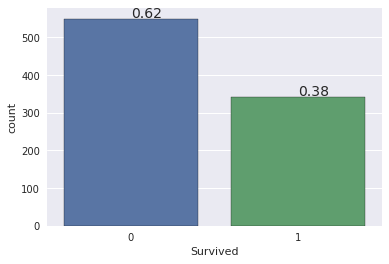

In [76]:
total = len(df_train)
ax = sns.countplot(x = 'Survived', data = df_train)

#To add text as a percentage
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    ax.text(x + w/2, h + 3, '{:.2f}'.format(h/total), fontsize = 14)

Only *38/%* of the people survived the diasaster.

### What was the survival rate for males and females?

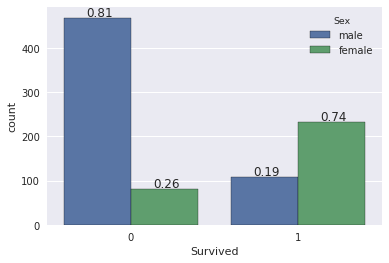

In [77]:
ax = sns.countplot('Survived', hue = 'Sex', data = df_train)
n_per_class = df_train['Sex'].value_counts()[['male', 'female']].values
total = n_per_class[0]

for i, p in enumerate(ax.patches):
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    total = n_per_class[int(i/2)] if(i%2 == 0) else total
    ax.text(x + w/3, h + 3, '{:.2f}'.format(h/total))

Only *19%* of the men survived whereas *74%* of the the women survived.

### Which class of passengers had the better/worse chances of survival?

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


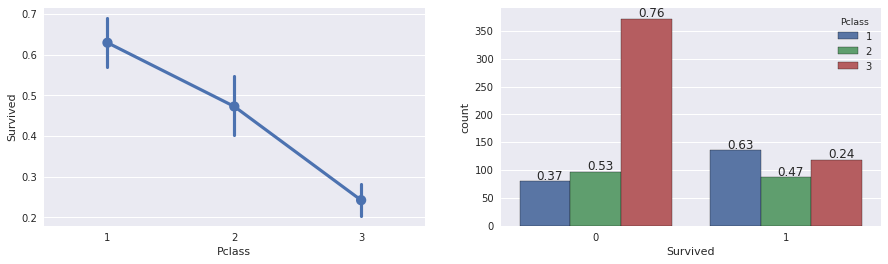

In [78]:
plt.figure(figsize= (15, 4))
plt.subplot(121)
sns.pointplot(y = 'Survived', x = 'Pclass', data = df_train)

plt.subplot(122)
ax = sns.countplot('Survived', hue = 'Pclass', data = df_train)
n_per_class = df_train['Pclass'].value_counts()[[1, 2 ,3]].values
total = n_per_class[0]

for i, p in enumerate(ax.patches):
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    total = n_per_class[int(i/2)] if(i%2 == 0) else total
    ax.text(x + w/3, h + 3, '{:.2f}'.format(h/total))
    
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins = True).style.background_gradient(cmap = 'cool')


Therefore in <br/>
Class 1: *63%* of the people survived.<br/>
Class 2: *47%* of the people Survived.<br/>
Class 3: *24%* of the people only survived.

We get an almost linear relationship between survival chances and the passengers class. Clearly survival rate decreases as we move from Class 1 to Class 3.

### Parch and SibSp

The columns 'Parch' and 'SibSp' stand for 'Parents and Children', 'Siblings'. We can combine these two columns into a new column called 'Relatives' by simply adding the prior columns. Manual Feature Engineering Like this can help us improve our score.

In [79]:
df_train['Relatives'] = df_train['Parch'] + df_train['SibSp']
df_train.drop(['Parch', 'SibSp'], axis = 1, inplace = True)

### How does the number of relatives affect the survival chances?

In [80]:
df_train.Relatives.value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Relatives, dtype: int64

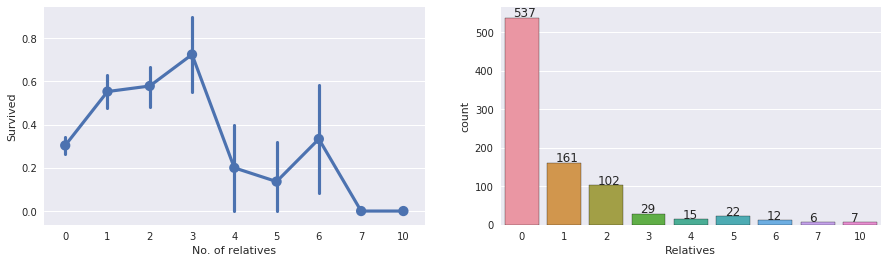

In [81]:
plt.figure(figsize= (15, 4))

plt.subplot(121)
ax = sns.pointplot(x = 'Relatives', y = 'Survived', data = df_train)
ax.set_xlabel("No. of relatives")

plt.subplot(122)
ax = sns.countplot('Relatives', data = df_train)
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    ax.text(x + w/4, h + 3, h)

We obersve the following things from the above graph:

1. People with 3 relatives have the highest chances of survival(29 people in total)
2. Surival rate is higher for people with 1 to 3 relatives
3. People having more than 3 relatives have very low chances of survival.

### Does the place where the ship was embarked affect survival chances?

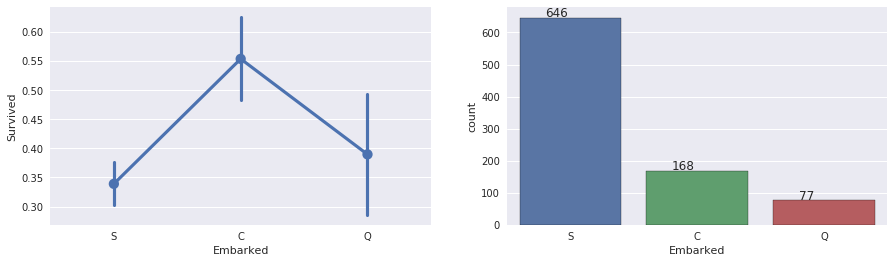

In [82]:
plt.figure(figsize= (15, 4))

plt.subplot(121)
sns.pointplot(x = 'Embarked', y = 'Survived', data = df_train)

plt.subplot(122)
ax = sns.countplot('Embarked', data = df_train)
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    ax.text(x + w/4, h + 3, h)

We can draw the following observations:

1. Most passengers have embarked from point S, which has the lowest chances of survival.
2. Passengers embarking from point C, have the highest chances of survival.

## Numerical or Continuous Cols

It is often useful to visualize the distribution of data in a continuous variable. We have two continous variables 'Age' and 'Fare'. Distribution of data becomes easy to visualize using ***boxplots***. 

In [83]:
df_train[numerical_cols].describe()

,Age,Fare
count,891.000000,891.000000
mean,29.699118,32.204208
std,13.002015,49.693429
min,0.420000,0.000000
25%,22.000000,7.910400
50%,29.699118,14.454200
75%,35.000000,31.000000
max,80.000000,512.329200


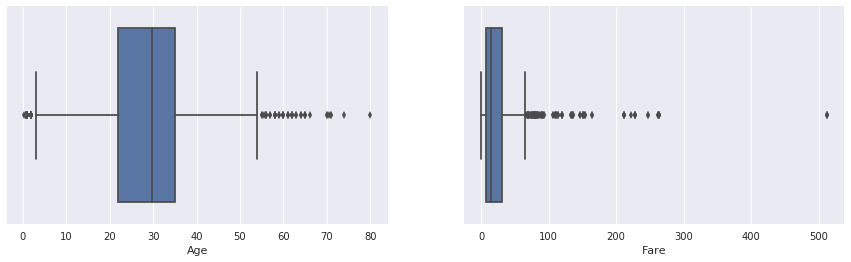

In [84]:
plt.figure(figsize = (15, 4))
plt.subplot(121)
sns.boxplot(x = df_train['Age'])
plt.subplot(122)
sns.boxplot(x = df_train['Fare'])

**Observations**:

1. ***AGE***: We can see that 50% of the passengers had age ranging between 22 to 35 years. The distribution is spread out indicating that it may come useful in our analysis.

2. ***FARE***: The box distribution for fare is very thin, indicating that most of the data in concentrated in a very small region. From the desribe() function above we can see that 50% of the fare is between 7 and 15, which is quite small comapared to the minimum and maximum values of 0 and 512. This distribution of fare gives us a hint that it is unlikely to help much in predicting the survival of passenger. Fare also has a large number of outliers indicated by the black dots.

We will further extend out analysis on Age, since it seems more interesting. This can be done by splitting age into categories. One obvious thing that comes into our mind is how the age varies for people who survived and who did not. A better insight can be gained be splitting it by sex.

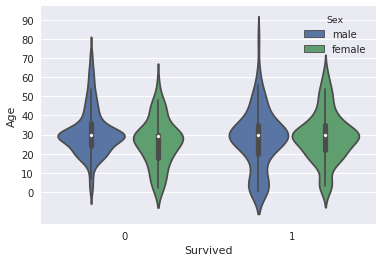

In [85]:
import numpy as np
sns.violinplot(x='Survived', y='Age', hue='Sex', data=df_train)
_ = plt.yticks(np.arange(0, 100, 10))

Titanic was known for following the rule of saving women and children first. Well lets have a brief check of that this theory

In [86]:
under_age = df_train['Age'] < 5
male = df_train['Sex'] == 'male'
survived = df_train['Survived']
print('Percentage of male children survived = ', ((male & under_age & survived).sum() / (male & under_age).sum())*100)
print('Percentage of female children survived = ', ((~male & under_age & survived).sum() / (~male & under_age).sum())*100)

Percentage of male children survived =  65.21739130434783
Percentage of female children survived =  70.58823529411765


***Lets get down to the most interesting part. Yes you are right, I am talking about predictions***

In [87]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import Imputer, StandardScaler
from xgboost import XGBClassifier

Pipeline is very useful to split your worklflow into steps. The output of one step is sent as the input to the next step. The final step must be a classification model.
The steps we need to perform are:

1. Break the features into ***Categorical*** and ***Numerical*** Columns

2. For ***Categorical*** Columns:
    1. ***Impute*** the Missing Values using ***largest frequency*** category
    2. Get dummies or ***one hot encoding*** of the categorical columns using ***pd.get_dummies()***
    3. Perform ***Feature Engineering***(You can try this but I am not going to do it here).
    
   For ***Numerical*** Columns:
    1. ***Impute*** the Missing Values using the ***mean***.
    2. ***Scale*** them to have a mean of 0 and a variance of 1
    3. Perform ***Feature Engineering***
    
3. Combine the Categorical and Numerical Columns using FeatureUnion.

4. Fit the combined features and labels using an appropriate classifier



In [88]:
df_train = pd.read_csv('train.csv')

In [89]:
cont_cols = ['Age', 'Fare', 'SibSp', 'Parch']
cat_cols = ['Pclass', 'Sex','Embarked']

select_cat_cols = FunctionTransformer(lambda x: x[cat_cols], validate=False)
select_cont_cols = FunctionTransformer(lambda x: x[cont_cols], validate=False)
select_one_hot = FunctionTransformer(lambda x: pd.get_dummies(x), validate=False)

In [90]:
def feature_eng(df):
    df['Relatives'] = df['SibSp'] + df['Parch']
    df.drop(['SibSp', 'Parch'], axis = 1, inplace=True)
    return df

feature_eng = FunctionTransformer(feature_eng, validate=False)
df_cont_imputer = FunctionTransformer(lambda x: x.fillna(x.mean(axis=0)), validate=False)
df_cat_imputer = FunctionTransformer(lambda x: x.fillna(x.mode(axis=0)), validate=False)

In [91]:
process_cat_cols = Pipeline([('selector', select_cat_cols), 
                             ('imputer', df_cat_imputer),
                             ('dummies', select_one_hot)])

process_cont_cols = Pipeline([('selector', select_cont_cols),
                              ('imputer', df_cont_imputer),
                              ('Feature Engineering', feature_eng),
                              ('scaler', StandardScaler())])

join_cat_cont = FeatureUnion(transformer_list = [('cat', process_cat_cols), ('cont', process_cont_cols)])
pipeline = make_pipeline(join_cat_cont, XGBClassifier(n_estimators=10))

In [92]:
pipeline.fit(df_train, df_train['Survived'])

Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('cat', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x7f03dbaa1730>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecate...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

Our pipeline looks good. Lets get a measure of how well our pipeline performs using the cross_val_score

In [93]:
print(cross_val_score(pipeline, df_train, df_train['Survived']).mean())
print(pipeline.score(df_train, df_train['Survived']))

0.8181818181818182
0.8338945005611672


In [94]:
df_test = pd.read_csv('test.csv')
predictions = pipeline.predict(df_test)
df_pred = pd.DataFrame({'PassengerId' : df_test['PassengerId'], 'Survived' : predictions})
df_pred.to_csv('titanic.csv', index = False)
pd.read_csv('titanic.csv')['Survived'].value_counts()

0    263
1    155
Name: Survived, dtype: int64